## Preparations

Let us first load all the python libraries again

In [ ]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.delphes import DelphesProcessor
from madminer.sampling import combine_and_shuffle
from madminer.utils.particle import MadMinerParticle

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 10. Run MadMiner at Detector Level

Let's first define the input file, the number of samples and *effective* number of samples

In [2]:
lhedatafile = 'data/madminer_lhedata.h5'
detectordatafile='data/madminer_detectordata.h5'
pythiadatafile='data/madminer_pythiadata.h5'

nsamples = 100000

### 10a) Run the Data Augmentation and Machine Learning part with Detetector Level Data

First, we once again augment the data and machine learning part again. Here  `n_samples` should be choosen similar to the effective number of events, which also depends on the cuts choosen earlier. 

In [3]:
sa = SampleAugmenter(detectordatafile, debug=False)

n_estimators = 5

for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_detector/',
        filename='train{}'.format(i)
    )

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_detector/',
    filename='test',
    switch_train_test_events=True
)

Next, we use the perform the ML part

In [4]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_detector/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_detector/t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
    
    n_epochs=100,
    n_hidden=(100,100,100,100),
    activation='tanh',
    initial_lr=0.001,
    final_lr=0.0001
)

ensemble.save('models/samples_detector')

### 10b) Run the Data Augmentation and Machine Learning part with Pythia Level Data

Now we repeat the same procedure, but with the pythia level data

In [5]:
sa = SampleAugmenter(pythiadatafile, debug=False)

n_estimators = 5

for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_pythia/',
        filename='train{}'.format(i)
    )

x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_pythia/',
    filename='test',
    switch_train_test_events=True
)

In [6]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_pythia/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_pythia/t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
    
    n_epochs=100,
    n_hidden=(100,100,100,100),
    activation='tanh',
    initial_lr=0.001,
    final_lr=0.0001
)

ensemble.save('models/samples_pythia')

### 10c) Obtain the Fisher Info

Now let's evaluate the Fisher Info again

In [8]:
fisher_parton = FisherInformation(lhedatafile)

fi_ml_mean, fi_ml_covariance = fisher_parton.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000.
)

fi_metonly_mean, fi_metonly_covariance = fisher_parton.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_metonly',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000.
)

fi_truth_mean, fi_truth_covariance = fisher_parton.calculate_fisher_information_full_truth(
    theta=[0.,0.],
    luminosity=300*1000.
)

fisher_detector = FisherInformation(detectordatafile, debug=False)

fi_detector_mean, fi_detector_covariance = fisher_detector.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_detector',
    unweighted_x_sample_file='data/samples_detector/x_test.npy',
    luminosity=300*1000.
)

fisher_pythia = FisherInformation(pythiadatafile, debug=False)

fi_pythia_mean, fi_pythia_covariance = fisher_pythia.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_pythia',
    unweighted_x_sample_file='data/samples_pythia/x_test.npy',
    luminosity=300*1000.
)

And let's plot the result

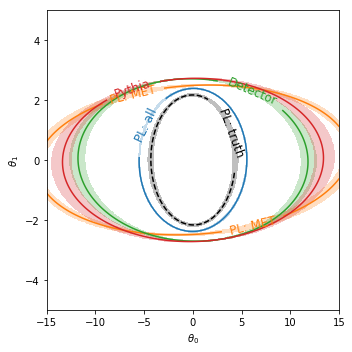

In [9]:
_ = plot_fisher_information_contours_2d(
    [fi_ml_mean, fi_metonly_mean, fi_detector_mean,fi_pythia_mean,fi_truth_mean ],
    [fi_ml_covariance, fi_metonly_covariance,fi_detector_covariance, fi_pythia_covariance,fi_truth_covariance],
    colors=[u'C0',u'C1',u'C2',u'C3',"black"],
    linestyles=["solid","solid","solid","solid","dashed"],
    inline_labels=["PL: all","PL: MET","Detector","Pythia","PL: truth"],
    xrange=(-15,15),
    yrange=(-5,5)
)